# YOLOv2 示範

快速介紹如何使用Darknet預先訓練的YOLOv2模型來檢測對象。

### 載入函數庫

In [1]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes, normalize, draw_pil_image_boxes

import random
import colorsys
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

Using TensorFlow backend.


### Darknet預訓練YOLOv2模型下載
從[YOLO官方網站](http://pjreddie.com/darknet/yolo/)下載Darknet模型的設置檔與權重檔到專案根目錄。
這個範例使用: [YOLOv2 608x608 權重檔(yolo.weights)](https://pjreddie.com/media/files/yolo.weights)

### 配置

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 驗證用的圖像目錄，預設為"images/"
TEST_PATH = os.path.join(ROOT_DIR, "images")

In [4]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
#LABELS = ["person","bird","cat","cow","dog","horse","sheep","aeroplane","bicycle","boat","bus","car","motorbike","train","bottle","chair","diningtable","pottedplant","sofa","tv"]
IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [5]:
wt_path = 'yolo.weights' # 原始Darknet權重檔
#wt_path = 'yolo-voc.weights'

### 構建YOLOv2的網絡結構

In [6]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [7]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)

output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
conv_1 (Conv2D)                  (None, 416, 416, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
norm_1 (BatchNormalization)      (None, 416, 416, 32)  128         conv_1[0][0]                     
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 416, 416, 32)  0           norm_1[0][0]                     
___________________________________________________________________________________________

norm_12 (BatchNormalization)     (None, 26, 26, 256)   1024        conv_12[0][0]                    
____________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)       (None, 26, 26, 256)   0           norm_12[0][0]                    
____________________________________________________________________________________________________
conv_13 (Conv2D)                 (None, 26, 26, 512)   1179648     leaky_re_lu_12[0][0]             
____________________________________________________________________________________________________
norm_13 (BatchNormalization)     (None, 26, 26, 512)   2048        conv_13[0][0]                    
____________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)       (None, 26, 26, 512)   0           norm_13[0][0]                    
___________________________________________________________________________________________

____________________________________________________________________________________________________


YOLOv2模型的最後卷積層"conv2d_23"的輸出為 (19, 19, 425)

* 最後的features map的維度是19x19x425 (為什麼是425)
* 主要是因為YOLOv2把整個圖像分成19x19個小區塊(cell)
* 而每個小區塊(cell)要predict"num_anchors(5)"個邊界框(bounding boxes)
* 因此(19, 19, 425)中的前2個維度就是定義每一個小區塊(cell), 而"425"則代表著:
    - x, y, width, height (定義邊界框的座標) -> 4個浮點數
    - 邊界框裡包含物體的信心分數(confidence score) -> 1個浮點數
    - 每一種類別的機率(num_classes) -> 80個浮點數 (MS Coco的資料集有80種圖像類別)


### 載入Darknet預訓練權重進到模型中

In [9]:
weight_reader = WeightReader(wt_path)

weight_reader.reset()

nb_conv = 23 # 總共有23層的卷積層

# 迭代每一層的神經層模組(conv + norm), 並賦予權重值
for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i)) # 取出某特定卷積層
    
    # 在conv_1~conv_22的卷積組合裡都包含了"conv + norm"二層, 只有conv_23是獨立一層    
    if i < nb_conv: 
        print("handle norm_" + str(i) + " start")
        norm_layer = model.get_layer('norm_' + str(i)) # 取得BatchNormalization層
        
        size = np.prod(norm_layer.get_weights()[0].shape) # 取得BatchNormalization層的參數量
        print("shape: ", norm_layer.get_weights()[0].shape)
        
        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
        print("handle norm_" + str(i) + " completed")
        
    if len(conv_layer.get_weights()) > 1:
        print("handle conv_" + str(i) + " start")  
        print("len:",len(conv_layer.get_weights()))
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        print("handle conv_" + str(i) + " completed")
    else:
        print("handle conv_" + str(i) + " start")        
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
        print("handle conv_" + str(i) + " completed")
        

handle norm_1 start
shape:  (32,)
handle norm_1 completed
handle conv_1 start
handle conv_1 completed
handle norm_2 start
shape:  (64,)
handle norm_2 completed
handle conv_2 start
handle conv_2 completed
handle norm_3 start
shape:  (128,)
handle norm_3 completed
handle conv_3 start
handle conv_3 completed
handle norm_4 start
shape:  (64,)
handle norm_4 completed
handle conv_4 start
handle conv_4 completed
handle norm_5 start
shape:  (128,)
handle norm_5 completed
handle conv_5 start
handle conv_5 completed
handle norm_6 start
shape:  (256,)
handle norm_6 completed
handle conv_6 start
handle conv_6 completed
handle norm_7 start
shape:  (128,)
handle norm_7 completed
handle conv_7 start
handle conv_7 completed
handle norm_8 start
shape:  (256,)
handle norm_8 completed
handle conv_8 start
handle conv_8 completed
handle norm_9 start
shape:  (512,)
handle norm_9 completed
handle conv_9 start
handle conv_9 completed
handle norm_10 start
shape:  (256,)
handle norm_10 completed
handle conv_10 

## 圖像的物體偵測

In [10]:
# 進行預測時不需要輸入BoundingBox, 給予一個空白的張量
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

#### 輸入圖像前處理

In [12]:
# 載入圖像
image = Image.open(os.path.join(TEST_PATH, "dog.jpg"))
print("Before image resize: ", np.array(image, dtype='float32').shape)

# 檢查模型的Input圖像大小
model_image_size = (IMAGE_H, IMAGE_W)

# 修改輸入圖像大小來符合模型的要求
#resized_iamge = image.resize(tuple(reversed(model_image_size))) # 在PIL的圖像縮放是 resize((width, height),..)
resized_iamge = image.resize((IMAGE_W, IMAGE_H)) # 在PIL的圖像縮放是 resize((width, height),..)
image_data = np.array(resized_iamge, dtype='float32') # (img_height, img_width, img_channels)
print("After image resize: ", image_data.shape)    
# 進行圖像歸一處理
image_data /= 255.
# 增加"批次"的維度
print("Before expand dims:",image_data.shape) # (img_height, img_width, img_channels)
image_data = np.expand_dims(image_data, 0) # 增加 batch dimension
print("After expand dims:",image_data.shape) # (sample_size, img_height, img_width, img_channels)

Before image resize:  (576, 768, 3)
After image resize:  (416, 416, 3)
Before expand dims: (416, 416, 3)
After expand dims: (1, 416, 416, 3)


#### 進行圖像物體偵測

(1, 13, 13, 5, 85)
0.7442524202 0.219960609166 0.346521768877 0.155476253382 0.799979 7 truck
0.452833508741 0.484686403469 0.563362244419 0.533842808749 0.839901 1 bicycle
0.293720159075 0.652673090028 0.259692287562 0.528157912841 0.78181 16 dog


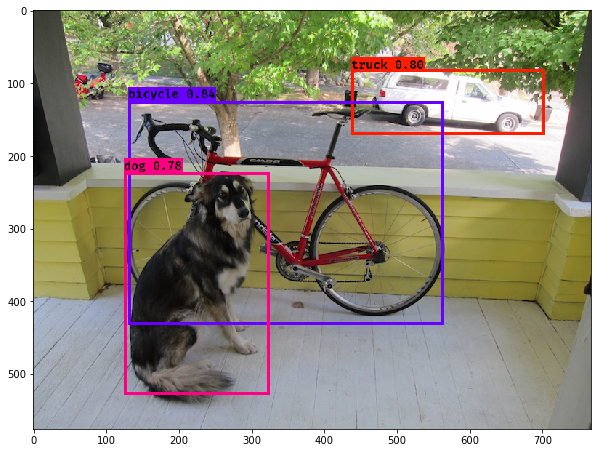

In [13]:
# 進行預測
netout = model.predict([image_data, dummy_array])

# 打印網絡的輸出的張量shape
print(netout.shape)

# 取得預測結果的BoundBox(x, y, w, h, confidence, classes)物件列表
boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, # 
                      nb_class=CLASS) # 有多少種類別

# 打印找到且經過閥值過濾後的邊界框與預測結果
for i,box in enumerate(boxes):
    print(box.x,box.y,box.w, box.h, box.get_score(), box.get_label() ,LABELS[box.get_label()] )

# "draw_pil_image_boxes"
# 一個簡單把邊界框與預測結果打印到原始圖像上的工具函式
# 參數: image 是PIL.Image物件
#       boxes 是偵測的結果
#       labels 是模型訓練的圖像類別列表
image = draw_pil_image_boxes(image, boxes, labels=LABELS)

plt.figure(figsize=(10,10)) # 設定展示的圖像大小
plt.imshow(image)           
plt.show()